In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, glob, re
import numpy as np
import tqdm
import seaborn as sns
from prody import *

# Load and prepare data for clustering

In [3]:
df_ie_master = pd.read_excel('/opt/experiments/pep_hla_dynamics/data_compiled/df_ie_master_vdw.xlsx')

In [4]:
df_ie_master

,Unnamed: 0,IE,res1_index,res2_index,res1_chid,res2_chid,res1_resnum,res2_resnum,subtype,peptide
0,0,-1.914090,376,377,C,C,4,5,HLA_A_68_02,FVANFSMEL
1,1,-0.140101,65,377,A,C,66,5,HLA_A_68_02,FVANFSMEL
2,2,-0.299177,72,379,A,C,73,7,HLA_A_68_02,FVANFSMEL
3,3,-0.005925,99,373,A,C,100,1,HLA_A_68_02,FVANFSMEL
4,4,-0.955094,380,79,C,A,8,80,HLA_A_68_02,FVANFSMEL
...,...,...,...,...,...,...,...,...,...,...
693831,268,-0.291101,378,69,C,A,2,70,HLA_B_35_01,FPYTGDPPY
693832,269,-3.457709,379,158,C,A,3,159,HLA_B_35_01,FPYTGDPPY
693833,270,1.425141,378,4,C,A,2,5,HLA_B_35_01,FPYTGDPPY
693834,271,-0.029046,377,380,C,C,1,4,HLA_B_35_01,FPYTGDPPY


In [5]:
# Examine the data structure
print("Data shape:", df_ie_master.shape)
print("\nColumns:", df_ie_master.columns.tolist())
print("\nUnique subtypes:", df_ie_master['subtype'].nunique())
print("Unique peptides:", df_ie_master['peptide'].nunique())
print("\nChain ID combinations:")
print(df_ie_master.groupby(['res1_chid', 'res2_chid']).size())

Data shape: (693836, 10)

Columns: ['Unnamed: 0', 'IE', 'res1_index', 'res2_index', 'res1_chid', 'res2_chid', 'res1_resnum', 'res2_resnum', 'subtype', 'peptide']

Unique subtypes: 15
Unique peptides: 2087

Chain ID combinations:
res1_chid  res2_chid
A          C            341567
B          C                 9
C          A            290123
           B                17
           C             62120
dtype: int64


In [6]:
# Filter for peptide-HLA interactions (C chain = peptide, A chain = HLA)
# We want interactions where one chain is C (peptide) and the other is A (HLA)
peptide_hla_interactions = df_ie_master[
    ((df_ie_master['res1_chid'] == 'C') & (df_ie_master['res2_chid'] == 'A')) |
    ((df_ie_master['res1_chid'] == 'A') & (df_ie_master['res2_chid'] == 'C'))
].copy()

print(f"Filtered data shape: {peptide_hla_interactions.shape}")
print(f"Original data shape: {df_ie_master.shape}")
print(f"Percentage of peptide-HLA interactions: {100 * len(peptide_hla_interactions) / len(df_ie_master):.2f}%")

Filtered data shape: (631690, 10)
Original data shape: (693836, 10)
Percentage of peptide-HLA interactions: 91.04%


In [7]:
# Standardize the data so that we always have peptide residue info first, HLA residue info second
# This will make it easier to create consistent feature vectors

def standardize_interaction(row):
    """Ensure peptide residue info comes first, HLA residue info comes second"""
    if row['res1_chid'] == 'C':  # res1 is peptide
        return {
            'peptide_resnum': row['res1_resnum'],
            'hla_resnum': row['res2_resnum'],
            'peptide_index': row['res1_index'],
            'hla_index': row['res2_index'],
            'IE': row['IE'],
            'subtype': row['subtype'],
            'peptide': row['peptide']
        }
    else:  # res2 is peptide
        return {
            'peptide_resnum': row['res2_resnum'],
            'hla_resnum': row['res1_resnum'],
            'peptide_index': row['res2_index'],
            'hla_index': row['res1_index'],
            'IE': row['IE'],
            'subtype': row['subtype'],
            'peptide': row['peptide']
        }

# Apply standardization
standardized_data = []
for _, row in tqdm.tqdm(peptide_hla_interactions.iterrows(), total=len(peptide_hla_interactions), desc="Standardizing interactions"):
    standardized_data.append(standardize_interaction(row))

df_standardized = pd.DataFrame(standardized_data)
print(f"Standardized data shape: {df_standardized.shape}")
df_standardized.head()

Standardizing interactions: 100%|██████████| 631690/631690 [00:15<00:00, 40244.44it/s]


Standardized data shape: (631690, 7)


,peptide_resnum,hla_resnum,peptide_index,hla_index,IE,subtype,peptide
0,5,66,377,65,-0.140101,HLA_A_68_02,FVANFSMEL
1,7,73,379,72,-0.299177,HLA_A_68_02,FVANFSMEL
2,1,100,373,99,-0.005925,HLA_A_68_02,FVANFSMEL
3,8,80,380,79,-0.955094,HLA_A_68_02,FVANFSMEL
4,8,72,380,71,-0.008256,HLA_A_68_02,FVANFSMEL


In [8]:
# Create feature vectors for each peptide-subtype combination
# Each vector will contain IE values for all peptide-HLA residue interactions

def create_feature_vector(group):
    """Create a feature vector for a peptide-subtype combination"""
    # Sort by peptide residue number and HLA residue number for consistency
    group_sorted = group.sort_values(['peptide_resnum', 'hla_resnum'])
    
    # Create a unique identifier for each peptide-HLA residue pair
    group_sorted['interaction_id'] = (group_sorted['peptide_resnum'].astype(str) + '_' + 
                                     group_sorted['hla_resnum'].astype(str))
    
    # Return the IE values as a series with interaction IDs as index
    return pd.Series(group_sorted['IE'].values, index=group_sorted['interaction_id'])

print("Creating feature vectors for each peptide-subtype combination...")
feature_vectors = df_standardized.groupby(['peptide', 'subtype']).apply(create_feature_vector)

print(f"Feature vectors shape: {feature_vectors.shape}")
print(f"Number of unique peptide-subtype combinations: {len(feature_vectors)}")

# Convert to DataFrame where each row is a peptide-subtype combination
# and each column is a peptide-HLA residue interaction
clustering_matrix = feature_vectors.unstack(level=-1)
print(f"Clustering matrix shape: {clustering_matrix.shape}")

# Fill NaN values with 0 (interactions that don't exist)
clustering_matrix = clustering_matrix.fillna(0)

print(f"Final clustering matrix shape: {clustering_matrix.shape}")
print(f"Number of features (peptide-HLA interactions): {clustering_matrix.shape[1]}")
print(f"Number of samples (peptide-subtype combinations): {clustering_matrix.shape[0]}")

clustering_matrix.head()

Creating feature vectors for each peptide-subtype combination...


Feature vectors shape: (631690,)
Number of unique peptide-subtype combinations: 631690
Clustering matrix shape: (2605, 780)
Final clustering matrix shape: (2605, 780)
Number of features (peptide-HLA interactions): 780
Number of samples (peptide-subtype combinations): 2605


/tmp/ipykernel_3579902/2845629192.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_vectors = df_standardized.groupby(['peptide', 'subtype']).apply(create_feature_vector)


,interaction_id,1_10,1_100,1_101,1_102,1_11,1_113,1_114,1_154,1_155,1_156,...,9_86,9_87,9_9,9_93,9_94,9_95,9_96,9_97,9_98,9_99
peptide,subtype,,,,,,,,,,,,,,,,,,,,,
AAAAFEAAL,HLA_C_14_02,0.0,-0.005831,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,-0.464258,-0.045878,-1.436696,0.000000,0.0,0.0
AAAANTTAL,HLA_C_03_03,0.0,-0.003669,-0.003392,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,-0.004387,0.0,0.000000,-1.559280,-0.062136,-0.115756,0.0,0.0
AAAQGQAPL,HLA_C_14_02,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-0.015665,0.0,...,0.0,0.0,0.000000,0.0,-0.672877,-0.054027,-1.061489,0.000000,0.0,0.0
AAAVAYPEL,HLA_C_03_03,0.0,-0.004976,-0.003273,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,-0.112068,-0.052490,-0.078330,0.0,0.0
AAAWYLWEV,HLA_A_02_01,0.0,-0.008443,-0.010076,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,-0.065273,0.000000,-0.314170,0.0,0.0


In [9]:
# Filter to include only interactions of peptide residues 2 and 9
clustering_matrix_filtered = clustering_matrix.filter(regex='^(2_|9_)', axis=1)
print(f"Filtered clustering matrix shape (residues 2 and 9 only): {clustering_matrix_filtered.shape}")
clustering_matrix_filtered.head()

Filtered clustering matrix shape (residues 2 and 9 only): (2605, 150)


,interaction_id,2_10,2_100,2_101,2_102,2_113,2_114,2_115,2_154,2_155,2_156,...,9_86,9_87,9_9,9_93,9_94,9_95,9_96,9_97,9_98,9_99
peptide,subtype,,,,,,,,,,,,,,,,,,,,,
AAAAFEAAL,HLA_C_14_02,0.0,-0.001209,0.000000,0.0,-0.002471,0.0,0.0,0.0,-0.013744,0.000000,...,0.0,0.0,0.000000,0.0,-0.464258,-0.045878,-1.436696,0.000000,0.0,0.0
AAAANTTAL,HLA_C_03_03,0.0,-0.005247,-0.000438,0.0,0.000000,0.0,0.0,0.0,0.000000,-0.002662,...,0.0,0.0,-0.004387,0.0,0.000000,-1.559280,-0.062136,-0.115756,0.0,0.0
AAAQGQAPL,HLA_C_14_02,0.0,-0.002488,0.000000,0.0,0.000000,0.0,0.0,0.0,-0.024707,0.000000,...,0.0,0.0,0.000000,0.0,-0.672877,-0.054027,-1.061489,0.000000,0.0,0.0
AAAVAYPEL,HLA_C_03_03,0.0,-0.005464,-0.000376,0.0,0.000000,0.0,0.0,0.0,0.000000,-0.004106,...,0.0,0.0,0.000000,0.0,0.000000,-0.112068,-0.052490,-0.078330,0.0,0.0
AAAWYLWEV,HLA_A_02_01,0.0,-0.002506,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,-0.065273,0.000000,-0.314170,0.0,0.0


In [10]:
# Filter to exclude weak interactions, e.g. those with |IE| > 1.4 only for maximum 20 peptide-subtype pairs
# This step is optional and can be adjusted based on the analysis needs
interaction_strength = (clustering_matrix_filtered.abs() > 1.4).sum(axis=0)
weak_interactions = interaction_strength[interaction_strength <= 20].index
# Exclude weak interactions
clustering_matrix_filtered_weak = clustering_matrix_filtered.drop(columns=weak_interactions)
print(f"Clustering matrix shape after filtering weak interactions: {clustering_matrix_filtered_weak.shape}")

Clustering matrix shape after filtering weak interactions: (2605, 53)


# Essential site scanning analysis

@> PDB file is found in working directory (1uxs.pdb.gz).
@> 3915 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Kirchhoff was built in 0.01s.
@> 10 modes were calculated in 0.01s.
@> Matching 10 modes across 386 modesets... [ 99%] 1sNo artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


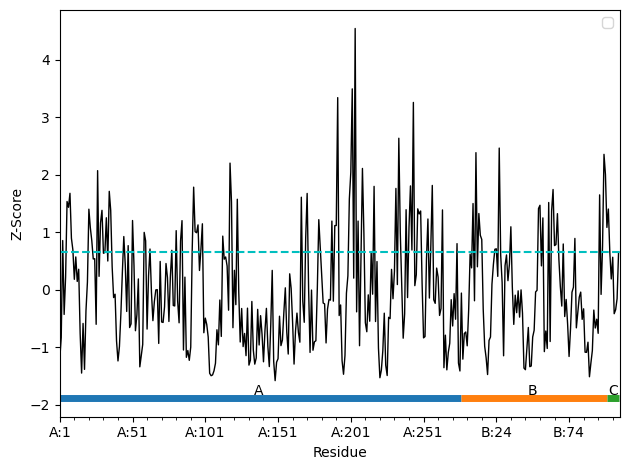

In [11]:
# Parse an MHC structure
# We assume this will represent the general topology of the MHC molecule for simplicity.
syst = parsePDB('1UXS')

# Construct an ESSA object
essa = ESSA()

# Set the system by defining chain C (the nonamer peptide) as the ligand.
essa.setSystem(syst, lig='C')

# Calculate the essential sites
essa.scanResidues()

# Show the ESSA profile
essa.showESSAProfile()


In [12]:
# Get the ESSA Z-scores
res_zscores = essa.getESSAZscores()

# Annonate Z scores based on their chain and residue numbers
res_zscores_annotated = {}

i = 0
# For each element in the Z-scores
for i in range(len(res_zscores)):
    res = syst.select(f"resindex {i}")
    chain_id = res.getChids()[0]
    resnum = res.getResnums()[0]
    zscore = res_zscores[i]
    res_zscores_annotated[f"{chain_id}_{resnum}"] = zscore

In [13]:
# Convert the annotated Z-scores to a DataFrame for easier handling
df_zscores = pd.DataFrame.from_dict(res_zscores_annotated, orient='index', columns=['Z-score'])

# Order by Z-score
df_zscores = df_zscores.sort_values(by='Z-score', ascending=False)

In [14]:
df_zscores.head()

,Z-score
A_204,4.547252
A_202,3.496704
A_192,3.344387
A_244,3.260735
A_234,2.637788


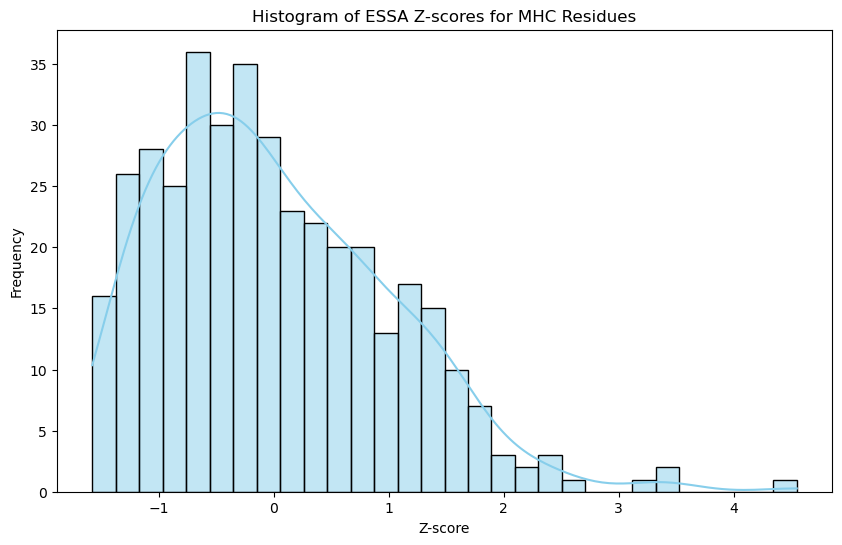

In [16]:
# Plot a histogram of z-scores
plt.figure(figsize=(10, 6))
sns.histplot(df_zscores['Z-score'], bins=30, kde=True, color='skyblue')
plt.title('Histogram of ESSA Z-scores for MHC Residues')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.show()

In [15]:
# Compute total Z-scores for each peptide-HLA interaction
interaction_zscores = {}

for column in clustering_matrix_filtered_weak.columns:
    # Parse the column name to extract peptide residue number and HLA residue number
    peptide_resnum, hla_resnum = column.split('_')
    
    # Create the corresponding keys for df_zscores
    peptide_key = f"C_{peptide_resnum}"  # Peptide residue (chain C)
    hla_key = f"A_{hla_resnum}"          # HLA residue (chain A)
    
    # Get Z-scores for both residues (default to 0 if not found)
    peptide_zscore = df_zscores.loc[peptide_key, 'Z-score'] if peptide_key in df_zscores.index else 0
    hla_zscore = df_zscores.loc[hla_key, 'Z-score'] if hla_key in df_zscores.index else 0
    
    # Sum the Z-scores
    total_zscore = peptide_zscore + hla_zscore
    interaction_zscores[column] = total_zscore

# Create a DataFrame with the interaction Z-scores
df_interaction_zscores = pd.DataFrame.from_dict(interaction_zscores, orient='index', columns=['Total_Z-score'])
df_interaction_zscores = df_interaction_zscores.sort_values(by='Total_Z-score', ascending=False)

print(f"Created interaction Z-scores dataframe with {len(df_interaction_zscores)} interactions")
print("\nTop 10 interactions by total Z-score:")
print(df_interaction_zscores.head(10))

print("\nBottom 10 interactions by total Z-score:")
print(df_interaction_zscores.tail(10))

Created interaction Z-scores dataframe with 53 interactions

Top 10 interactions by total Z-score:
       Total_Z-score
2_8         3.085850
2_167       3.017853
2_6         2.942622
2_7         2.842425
2_99        2.555323
2_45        2.333445
9_8         2.322257
2_9         2.304528
9_123       2.218719
2_63        2.116308

Bottom 10 interactions by total Z-score:
       Total_Z-score
9_143       0.320322
2_158       0.289070
9_117       0.288516
9_76        0.092303
9_83        0.068979
9_146       0.042894
9_142      -0.071825
9_144      -0.341430
9_148      -0.601423
9_145      -0.692767


In [18]:
# Filter interactions with total Z-score above a certain threshold, e.g., 1.0, in interaction_matrix_filtered_weak
threshold = 1.0
significant_interactions = df_interaction_zscores[df_interaction_zscores['Total_Z-score'] > threshold].index
interaction_matrix_final = clustering_matrix_filtered_weak[significant_interactions]
print(f"Final interaction matrix shape after filtering by Z-score > {threshold}: {interaction_matrix_final.shape}")
interaction_matrix_final.head()

Final interaction matrix shape after filtering by Z-score > 1.0: (2605, 29)


,interaction_id,2_8,2_167,2_6,2_7,2_99,2_45,9_8,2_9,9_123,2_63,...,2_5,9_84,2_160,2_67,2_64,9_78,9_115,2_66,9_74,9_116
peptide,subtype,,,,,,,,,,,,,,,,,,,,,
AAAAFEAAL,HLA_C_14_02,-0.012595,0.000000,-1.759542,-0.004924,-0.001885,0.000000,0.0,0.000000,-0.736165,-0.004211,...,0.000000,-0.010507,0.000000,0.000000,-0.005166,-0.048197,-1.105545,-0.547631,0.000000,-0.085309
AAAANTTAL,HLA_C_03_03,-0.006280,-0.157673,0.000000,-0.211530,-0.829837,-0.001242,0.0,-0.010581,-1.252100,1.957686,...,1.796737,1.867708,-0.005029,-1.096300,-0.013554,-0.170939,-0.021828,-0.610896,-0.318258,-1.660123
AAAQGQAPL,HLA_C_14_02,-0.004863,-0.001962,-0.378033,-0.002987,-0.003193,0.000000,0.0,0.000000,-0.693321,-0.003509,...,0.000000,-0.022214,0.000000,0.000000,-0.003338,-0.065912,-0.685559,-0.340306,0.000000,-0.097854
AAAVAYPEL,HLA_C_03_03,-0.006188,-0.179242,0.000000,-2.245352,-0.955811,-0.001039,0.0,0.812444,-2.168796,1.061803,...,1.819229,-1.648037,-0.006159,-1.264133,-0.015865,-0.207703,-0.024411,-1.158334,-0.227512,-2.342347
AAAWYLWEV,HLA_A_02_01,2.338886,-0.098807,0.000000,-1.944966,-1.114289,-0.330021,0.0,-0.277459,-1.050314,1.294827,...,2.248339,-0.072627,-0.001730,-0.236807,-0.020979,-0.057518,0.000000,-1.034976,-0.092153,-1.626245


In [ ]:
# Import clustering libraries
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Hierarchical clustering (seaborn clustermap)

Performing hierarchical clustering using seaborn clustermap...


/home/onur/anaconda3/envs/datascience/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/onur/anaconda3/envs/datascience/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/onur/anaconda3/envs/datascience/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


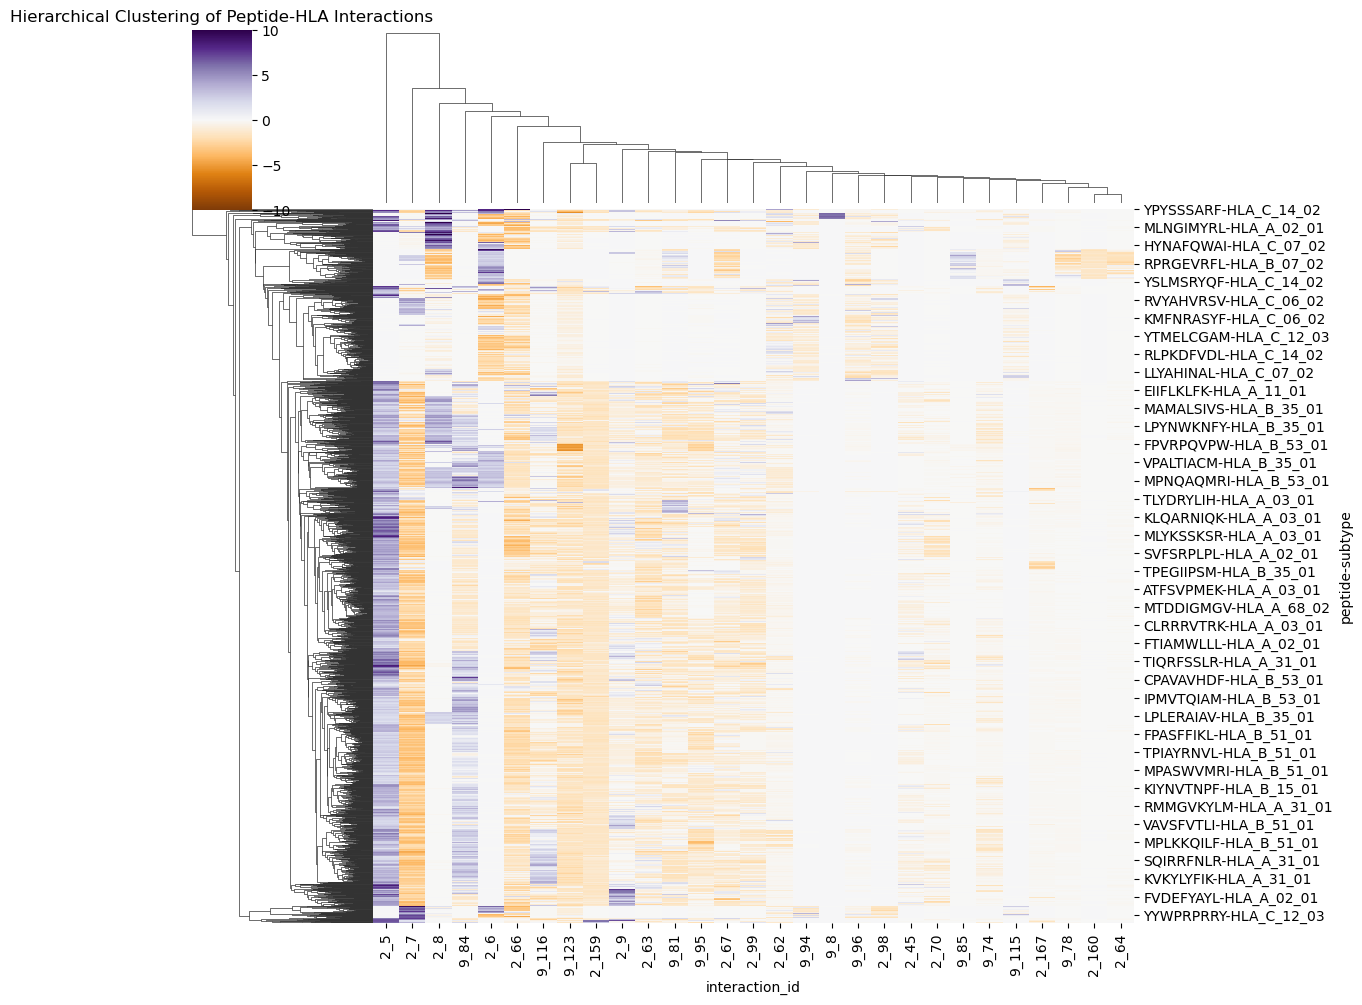

In [19]:
# Hierarchical clustering using seaborn clustermap
print("Performing hierarchical clustering using seaborn clustermap...")
# Create a clustermap
clustermap = sns.clustermap(interaction_matrix_final, method='average', metric='euclidean', cmap='PuOr', vmin=-10, vmax=10, figsize=(12, 10))
plt.title('Hierarchical Clustering of Peptide-HLA Interactions')
plt.show()

# k-means clustering

In [20]:
# Import k-means clustering library
from sklearn.cluster import KMeans

# Set the number of clusters
num_clusters = 5

# Perform k-means clustering of interaction_matrix_final
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(interaction_matrix_final)
cluster_labels = kmeans.labels_
# Add cluster labels to the interaction matrix_final DataFrame
interaction_matrix_final['Cluster'] = cluster_labels
interaction_matrix_final.head()

/tmp/ipykernel_3579902/4260223274.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interaction_matrix_final['Cluster'] = cluster_labels


,interaction_id,2_8,2_167,2_6,2_7,2_99,2_45,9_8,2_9,9_123,2_63,...,9_84,2_160,2_67,2_64,9_78,9_115,2_66,9_74,9_116,Cluster
peptide,subtype,,,,,,,,,,,,,,,,,,,,,
AAAAFEAAL,HLA_C_14_02,-0.012595,0.000000,-1.759542,-0.004924,-0.001885,0.000000,0.0,0.000000,-0.736165,-0.004211,...,-0.010507,0.000000,0.000000,-0.005166,-0.048197,-1.105545,-0.547631,0.000000,-0.085309,3
AAAANTTAL,HLA_C_03_03,-0.006280,-0.157673,0.000000,-0.211530,-0.829837,-0.001242,0.0,-0.010581,-1.252100,1.957686,...,1.867708,-0.005029,-1.096300,-0.013554,-0.170939,-0.021828,-0.610896,-0.318258,-1.660123,0
AAAQGQAPL,HLA_C_14_02,-0.004863,-0.001962,-0.378033,-0.002987,-0.003193,0.000000,0.0,0.000000,-0.693321,-0.003509,...,-0.022214,0.000000,0.000000,-0.003338,-0.065912,-0.685559,-0.340306,0.000000,-0.097854,3
AAAVAYPEL,HLA_C_03_03,-0.006188,-0.179242,0.000000,-2.245352,-0.955811,-0.001039,0.0,0.812444,-2.168796,1.061803,...,-1.648037,-0.006159,-1.264133,-0.015865,-0.207703,-0.024411,-1.158334,-0.227512,-2.342347,0
AAAWYLWEV,HLA_A_02_01,2.338886,-0.098807,0.000000,-1.944966,-1.114289,-0.330021,0.0,-0.277459,-1.050314,1.294827,...,-0.072627,-0.001730,-0.236807,-0.020979,-0.057518,0.000000,-1.034976,-0.092153,-1.626245,1


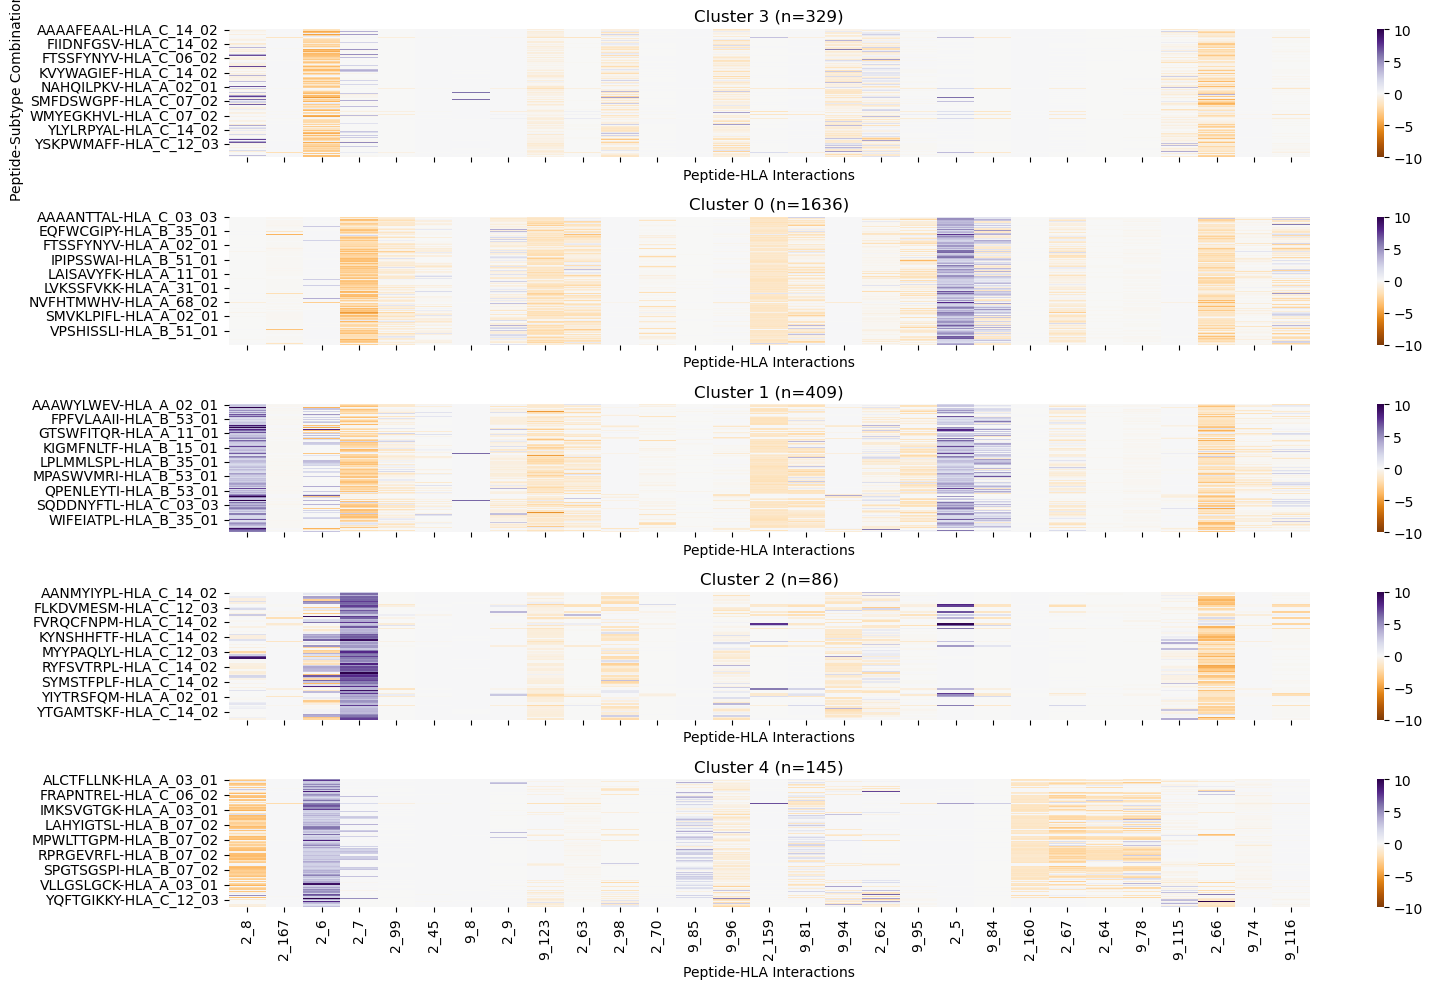

In [26]:
# Plot each cluster as a heatmap with cmap PuOr, vmin=-10, vmax=10 in subplots
unique_clusters = interaction_matrix_final['Cluster'].unique()
num_clusters = len(unique_clusters)
fig, axes = plt.subplots(num_clusters, 1, figsize=(16, 2 * num_clusters), sharex=True)
for i, cluster in enumerate(unique_clusters):
    cluster_data = interaction_matrix_final[interaction_matrix_final['Cluster'] == cluster].drop(columns=['Cluster'])
    sns.heatmap(cluster_data, ax=axes[i], cmap='PuOr', vmin=-10, vmax=10)
    axes[i].set_title(f'Cluster {cluster} (n={len(cluster_data)})')
    axes[i].set_xlabel('Peptide-HLA Interactions')
    axes[i].set_ylabel('Peptide-Subtype Combinations' if i == 0 else '')
plt.tight_layout()
plt.show()